In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle
from pydataset import data

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_regression

### Acquire data

In [2]:
swiss = data('swiss')

In [3]:
swiss.sample(5)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Rolle,60.5,60.8,16,10,7.72,16.3
Echallens,68.3,72.6,18,2,24.20,21.2
Le Locle,72.7,16.7,22,13,11.22,18.9
Avenches,68.9,60.7,19,12,4.43,22.7
Val de Ruz,77.6,37.6,15,7,4.97,20.0


In [4]:
swiss.shape

(47, 6)

In [5]:
swiss.describe()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
count,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000
mean,70.142553,50.659574,16.489362,10.978723,41.14383,19.942553
std,12.491697,22.711218,7.977883,9.615407,41.70485,2.912697
min,35.000000,1.200000,3.000000,1.000000,2.15000,10.800000
25%,64.700000,35.900000,12.000000,6.000000,5.19500,18.150000
50%,70.400000,54.100000,16.000000,8.000000,15.14000,20.000000
75%,78.450000,67.650000,22.000000,12.000000,93.12500,21.700000
max,92.500000,89.700000,37.000000,53.000000,100.00000,26.600000


In [6]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


### Prepare Data

In [7]:
# double check for nulls
swiss.isnull().any()

Fertility           False
Agriculture         False
Examination         False
Education           False
Catholic            False
Infant.Mortality    False
dtype: bool

In [8]:
# double check we have no empty spaces
swiss = swiss.replace(r'^\s*$', np.nan, regex=True)

In [9]:
swiss.isnull().any()

Fertility           False
Agriculture         False
Examination         False
Education           False
Catholic            False
Infant.Mortality    False
dtype: bool

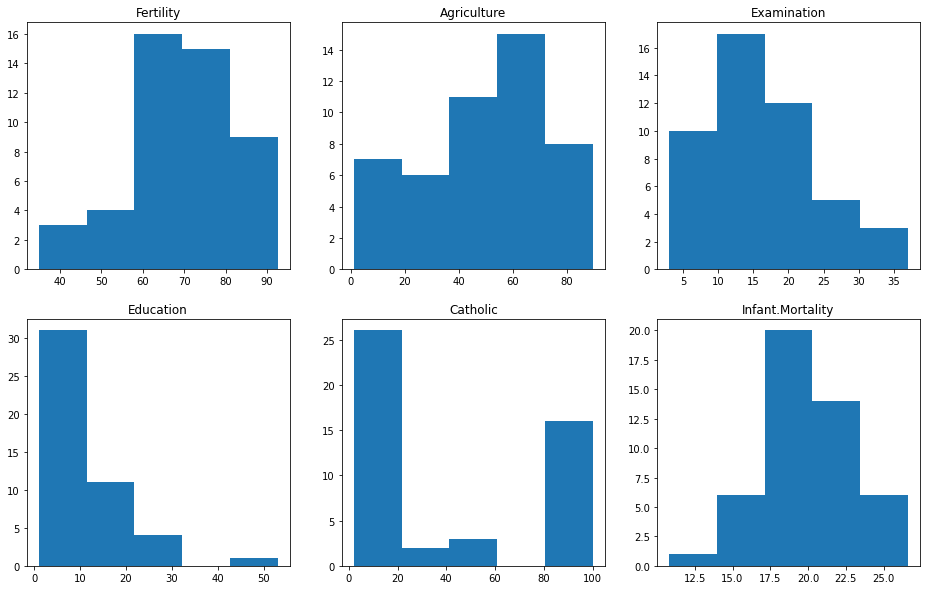

In [10]:
plt.figure(figsize=(16, 10))

# List of columns
cols = swiss.columns

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2,3, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    swiss[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

In [11]:
# cols = train.drop(columns='Fertility')
# y = train.Fertility

# for col in train[cols]:
#     sns.scatterplot(data=train, x=col, y=y)

In [12]:
# takeaways
# scale then split
type(cols)

pandas.core.indexes.base.Index

### Explore

In [13]:
swiss.sample(3)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Vevey,58.3,26.8,25,19,18.46,20.9
Rolle,60.5,60.8,16,10,7.72,16.3
St Maurice,65.0,75.9,9,9,99.06,17.8


In [14]:
# split our data and use train to explore
train, validate, test = wrangle.split_data(swiss)

train---> (25, 6)
validate---> (12, 6)
test---> (10, 6)


In [15]:
# take a look at correlation with fertility
corr = train.corr()
corr

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Fertility,1.000000,0.176194,-0.530508,-0.270200,0.657541,0.448141
Agriculture,0.176194,1.000000,-0.700832,-0.651919,0.449540,-0.257090
Examination,-0.530508,-0.700832,1.000000,0.769327,-0.584207,0.267298
Education,-0.270200,-0.651919,0.769327,1.000000,-0.258797,0.330789
Catholic,0.657541,0.449540,-0.584207,-0.258797,1.000000,0.085415
Infant.Mortality,0.448141,-0.257090,0.267298,0.330789,0.085415,1.000000


<AxesSubplot:>

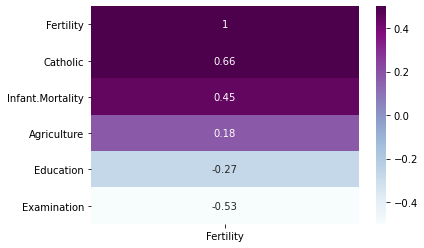

In [16]:
# create a heatmap
sns.heatmap(corr[['Fertility']].sort_values(by='Fertility', ascending=False), cmap="BuPu", vmin=-.5, vmax=.5, annot=True)

In [17]:
# assign our X coeffs and Y target
X_train = train.drop(columns='Fertility')
y_train = train.Fertility

X_validate = validate.drop(columns='Fertility')
y_validate = validate.Fertility

X_test = test.drop(columns='Fertility')
y_test = test.Fertility

numeric_cols = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test, numeric_cols)

### Feature Engineering

In [24]:
# take a look at our most important features via kbest function
print('The top three features using kbest are:', list(wrangle.select_kbest(X_train_scaled, y_train, 3)))

The top three features using kbest are: ['Examination', 'Catholic', 'Infant.Mortality']


In [25]:
# take a look at our most important features via RFE function
print('The top three features using RFE are:', list(wrangle.rfe(X_train_scaled, y_train, 3)))

The top three features using RFE are: ['Agriculture', 'Examination', 'Infant.Mortality']


### Modeling

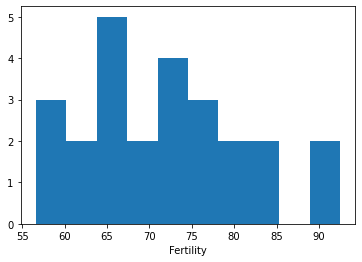

In [30]:
# plot our ytarget so we can visualize the distribution
plt.hist(y_train)
plt.xlabel('Fertility')
plt.show()